In [1]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import scipy.stats
from scipy.interpolate import interp1d

from root_to_np import get_tree, get_df, rename_tree_branches

Welcome to JupyROOT 6.26/04
END OF SCRIPT


In [2]:
run = [630,636]
pad_name = [37,38,27,28]
which_mcp = [1,1,2,2]

centers_from_fit = np.loadtxt('/home/evridiki/Desktop/JULY_RUNS/run_627_632_info/pad_centers.txt',
                delimiter=" ", unpack=False)
print('pads centers x = ',centers_from_fit[0])
print('pads centers y = ',centers_from_fit[1])

color = np.array(['red','blue','purple','green'])

pads centers x =  [27.46066004 17.44118157 27.35842914 17.33895067]
pads centers y =  [20.73989034 20.63765944 30.75936881 30.65713791]


In [3]:
data = []
for irun in run:
    tree = get_tree(irun)
    
    var_indexes = np.array([1,2,4,5,6,7])
    for index in range(4):
        var_indexes = np.append(var_indexes,[index*10+8,index*10+9,index*10+12,index*10+14,index*10+11]) 
    var_indexes = np.append(var_indexes,[67,65,66])
    
    data_single = get_df(tree,*var_indexes)
    
    old_names = ['mcp_gpeak','mcp_qall','mcp_t']
    new_names = ['mcp1_gpeak','mcp1_qall','mcp1_t']
    names = [old_names,new_names]
    data_single = rename_tree_branches(data_single,*names)
    
    print(len(data_single))
    data.append(data_single)

data = pd.concat(data)
print(data.head())
print(len(data))

['Pico;1']
['srs', 'mcp_gpeak', 'mcp_qall', 'mcp_tnaive', 'mcp_t', 'mcp2_gpeak', 'mcp2_qall', 'mcp2_t', 'mm1_gpeak', 'mm1_qall', 'mm1_tnaive', 'mm1_t', 'mm1_qe', 'mm1_pl3', 'mm1_qfit', 'mm1_xh', 'mm1_qh', 'mm1_gmin', 'mm2_gpeak', 'mm2_qall', 'mm2_tnaive', 'mm2_t', 'mm2_qe', 'mm2_pl3', 'mm2_qfit', 'mm2_xh', 'mm2_qh', 'mm2_gmin', 'mm3_gpeak', 'mm3_qall', 'mm3_tnaive', 'mm3_t', 'mm3_qe', 'mm3_pl3', 'mm3_qfit', 'mm3_xh', 'mm3_qh', 'mm3_gmin', 'mm4_gpeak', 'mm4_qall', 'mm4_tnaive', 'mm4_t', 'mm4_qe', 'mm4_pl3', 'mm4_qfit', 'mm4_xh', 'mm4_qh', 'mm4_gmin', 'nmm1_x', 'mm1_x', 'nmm1_y', 'mm1_y', 'nmm2_x', 'mm2_x', 'nmm2_y', 'mm2_y', 'nmm3_x', 'mm3_x', 'nmm3_y', 'mm3_y', 'nmm4_x', 'mm4_x', 'nmm4_y', 'mm4_y', 'ntracks', 'xy', 'chi2', 'track_flag', 'ndetsintrack', 'distnextcluster']
<Report start=0 stop=4538 source='/home/evridiki/Downloads/test_run630.root:/Pico;1'>
<Report start=4538 stop=9076 source='/home/evridiki/Downloads/test_run630.root:/Pico;1'>
<Report start=9076 stop=13614 source='/home

<Report start=163404 stop=167943 source='/home/evridiki/Downloads/test_run636.root:/Pico;1'>
<Report start=167943 stop=172482 source='/home/evridiki/Downloads/test_run636.root:/Pico;1'>
<Report start=172482 stop=177021 source='/home/evridiki/Downloads/test_run636.root:/Pico;1'>
<Report start=177021 stop=181560 source='/home/evridiki/Downloads/test_run636.root:/Pico;1'>
<Report start=181560 stop=186099 source='/home/evridiki/Downloads/test_run636.root:/Pico;1'>
<Report start=186099 stop=190638 source='/home/evridiki/Downloads/test_run636.root:/Pico;1'>
<Report start=190638 stop=195177 source='/home/evridiki/Downloads/test_run636.root:/Pico;1'>
<Report start=195177 stop=199350 source='/home/evridiki/Downloads/test_run636.root:/Pico;1'>
199350
   mcp1_gpeak  mcp1_qall      mcp1_t  mcp2_gpeak  mcp2_qall      mcp2_t  \
0    0.313779   3.629249  200.261986    0.329183   3.801939  197.282873   
1    0.407590   4.733348  201.549047    0.424461   4.972193  198.437085   
2    0.334093   3.823908

In [4]:
#define the cuts
mm_basic_cut= []

mcp_overflow = np.logical_and((data.mcp1_gpeak>0.3)*(data.mcp1_gpeak<=0.74),
                             (data.mcp2_gpeak>0.3)*(data.mcp2_gpeak<=0.74))
chi2_cut = (data.chi2<=40)*(data.track_flag>0)
mcp_basic_cut = mcp_overflow*chi2_cut

for index in range(4):
    pad = index+1
       
    mm_gpeak = f'mm{pad}_gpeak'
    mm_qall = f'mm{pad}_qall'
    mm_qe = f'mm{pad}_qe'
    mm_qfit = f'mm{pad}_qfit'
    mm_overflow = (data[mm_gpeak]>0.02)*(data[mm_gpeak]<0.36)*(data[mm_qe]>0)
    qe_line = (data[mm_qe]>30.*data[mm_gpeak])
    cut = np.logical_and(mm_overflow*mcp_basic_cut,qe_line)
    
    mm_basic_cut.append(cut)

In [5]:
class Distribution:
    def __init__(self, dataset,cut):
        self.dataset = dataset
        self.cut = cut
        
    def GetDataset(self):
        return self.dataset
    
    def GetCut(self):
        return self.cut
    
    def Scale(self,p2,p3):
        return p2*self.dataset[self.cut]+p3
 
    def GetHist(self,bins=100,range=[],density=True):
        if not range: #list is still empty
            range = [self.dataset[self.cut].min(),self.dataset[self.cut].max()]
        counts, edges = np.histogram(self.dataset[self.cut], range=range,
                             bins =bins, density = density)
        bin_centers = (edges[1:]+edges[:-1])/2
        return counts, edges, bin_centers
    
    def DisplayDensityHist(self,ax=plt ,color='black',bins=100,label=''):
        ax.hist(self.dataset[self.cut], bins =bins, 
                            color = color, histtype='step',label = label,density=True)
    
    def HistKDE(self):
        kde = scipy.stats.gaussian_kde(self.dataset[self.cut])
        return kde
    
    def PandasPlot(self,ax=plt,color='blue',bins=100,label='',range=[]):
        if not range: #list is still empty
            range = [self.dataset[self.cut].min(),self.dataset[self.cut].max()]
        data_ser = pd.Series(self.dataset[self.cut])
        data_ser.plot.hist(bins =bins, edgecolor='w', range=range,linewidth=0.2,
                            color = color,label = label,density=True,ax=ax)
    
    def FitFunction(self,f,p0, bins=100,range=[],density=True):
        c,_,b = self.GetHist(bins =bins,range=range, density = density)

        popt, pcov = curve_fit(f, b, c, p0=p0)
        
        return popt, np.sqrt(np.diag(pcov))
    

In [6]:
#a check if center in beam frame gives compatible x0, y0 params
x1 = centers_from_fit[0][0]
y1 = centers_from_fit[1][0]
x2 = centers_from_fit[0][1]
y2 = centers_from_fit[1][1]
x3 = centers_from_fit[0][2]
y3 = centers_from_fit[1][2]
x4 = centers_from_fit[0][3]
y4 = centers_from_fit[1][3]

x12 =(x1+x2)/2
x34 = (x3+x4)/2
y31 = (y3+y1)/2
y42 = (y4+y2)/2
print(x12)
print(x34)
print(y31)
print(y42)

x0 = (x12+x34)/2
y0 = (y31+y42)/2

print('x0 in beam frame should be at--->',x0)
print('y0 in beam frame should be at--->',y0)


22.450920803599026
22.348689904089028
25.749629570984872
25.647398671474868
x0 in beam frame should be at---> 22.399805353844027
y0 in beam frame should be at---> 25.69851412122987


In [7]:
#a check if theta is correct
dx = x2-x1
dy = y2-y1
u = np.arctan(dy/dx)
print('theta angle = ',u)
dx = x3-x4
dy = y3-y4
u = np.arctan(dy/dx)
print('theta angle = ',u)

theta angle =  0.01020286159781717
theta angle =  0.01020286159781717


In [8]:
def transfo(x,y,x0,y0, theta): #from sym to beam frame and vice versa
    dx=x-x0
    dy=y-y0
    return (dx*np.cos(theta)+dy*np.sin(theta), -dx*np.sin(theta)+dy*np.cos(theta))

#angle of beam frame with respect to local
theta_beam = -1.0203e-02 #result from minimization

#zero beam point with respect to local
zero_beam = [-2.2661e+01, -2.5469e+01]

#cross with respect to beam
cross_beam = transfo(0,0,zero_beam[0],zero_beam[1],theta_beam)
print('cross in beam. frame ',cross_beam)

#angle of local fr with respect to beam
theta_local = -theta_beam
cross_local = [0.,0.]
print('cross in local frame ',cross_local)

cross in beam. frame  (22.39996479308732, 25.69888050613195)
cross in local frame  [0.0, 0.0]


In [9]:
#a check if the transfo works properly
print('PAD1 :centers in local frame', transfo(x1,y1,cross_beam[0],cross_beam[1],theta_local) )
print('PAD2 :centers in local frame', transfo(x2,y2,cross_beam[0],cross_beam[1],theta_local) )
print('PAD3 :centers in local frame', transfo(x3,y3,cross_beam[0],cross_beam[1],theta_local) )
print('PAD4 :centers in local frame', transfo(x4,y4,cross_beam[0],cross_beam[1],theta_local) )


PAD1 :centers in local frame (5.0098361375002645, -5.010365432496202)
PAD2 :centers in local frame (-5.010163862499645, -5.010364045706329)
PAD3 :centers in local frame (5.009837524290137, 5.009634567503701)
PAD4 :centers in local frame (-5.010162475709773, 5.0096359542935724)


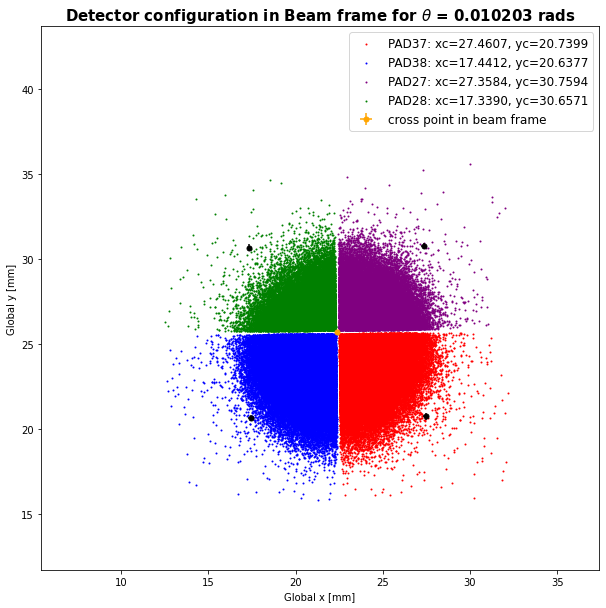

In [10]:
fig, ax = plt.subplots(figsize=(10,10))
for i,xy in enumerate(centers_from_fit.T):
    xc = xy[0]
    yc = xy[1]
    
    x = data.iloc[:,-4].values
    y = data.iloc[:,-3].values
    x,y = transfo(x,y,0,0,theta_local) #rotate only tracks
    
    
    square = np.logical_and(np.abs((x-xc)*np.cos(-theta_beam)+(y-yc)*np.sin(-theta_beam))<=4.91,
                            np.abs((y-yc)*np.cos(-theta_beam)-(x-xc)*np.sin(-theta_beam))<=4.91)

    mm_cut = np.logical_and(mm_basic_cut[i],square)
    
    xsym = x[mm_cut]
    ysym = y[mm_cut]
    
    
    ax.scatter(xsym,ysym,color = color[i],
             label =f'PAD{pad_name[i]}: xc={xc:.4f}, yc={yc:.4f}',s=1)
    ax.errorbar(xc,yc,yerr =0.2 ,xerr=0.15,color = 'black',
             fmt='o',markersize=5.)

ax.errorbar(cross_beam[0],cross_beam[1],yerr =0.035 ,xerr=0.039,color = 'orange',
             fmt='o',markersize=5.,label='cross point in beam frame')

plt.title(f'Detector configuration in Beam frame for $\\theta$ = {theta_local} rads', fontsize=15, fontweight='bold')
ax.set_xlim(cross_beam[0]-17,cross_beam[0]+15)
ax.set_ylim(cross_beam[1]-14,cross_beam[1]+18)
ax.legend(prop={'size': 12})
ax.set_xlabel('Global x [mm]')
ax.set_ylabel('Global y [mm]')
plt.show()

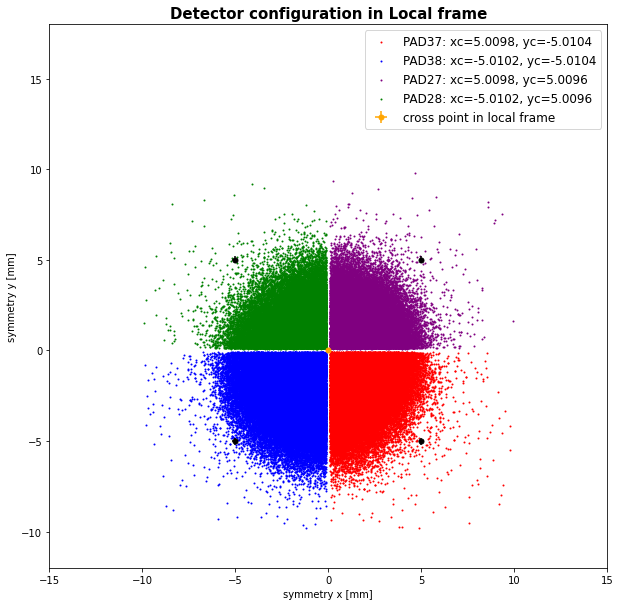

In [11]:
fig, ax = plt.subplots(figsize=(10,10))

for i,xy in enumerate(centers_from_fit.T):
    xc = xy[0]
    yc = xy[1]
    
    xc,yc = transfo(xc,yc,cross_beam[0],cross_beam[1],theta_local)
    
    x = data.iloc[:,-4].values
    y = data.iloc[:,-3].values
    x,y = transfo(x,y,cross_beam[0],cross_beam[1],theta_local) #rotate only tracks
    
    square = np.logical_and(np.abs(x-xc)<=4.91,
                            np.abs(y-yc)<=4.91)

    mm_cut = np.logical_and(mm_basic_cut[i],square)
    
    xsym = x[mm_cut]
    ysym = y[mm_cut]
    
    ax.scatter(xsym,ysym,color = color[i],
             label =f'PAD{pad_name[i]}: xc={xc:.4f}, yc={yc:.4f}',s=1)
    ax.errorbar(xc,yc,yerr =0.2 ,xerr=0.15,color = 'black',
             fmt='o',markersize=5.)
    
cross = transfo(cross_beam[0],cross_beam[1],cross_beam[0],cross_beam[1],theta_local)      
ax.errorbar(cross[0],cross[1],yerr =0.035 ,xerr=0.039,color = 'orange',
             fmt='o',markersize=5.,label='cross point in local frame')


    

ax.set_xlim(cross[0]-15,cross[0]+15)
ax.set_ylim(cross[1]-12,cross[1]+18)
plt.title(f'Detector configuration in Local frame', fontsize=15, fontweight='bold')
ax.legend(prop={'size': 12})
ax.set_xlabel('symmetry x [mm]')
ax.set_ylabel('symmetry y [mm]')
plt.show()

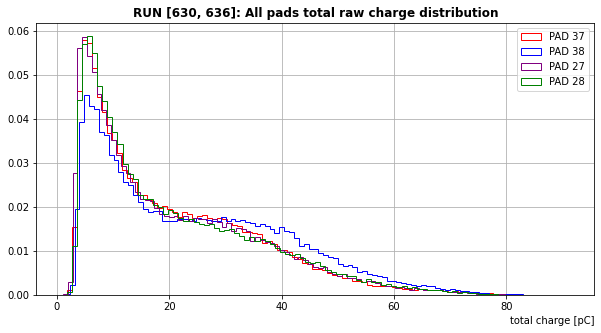

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))
qDist = [None]*4

for index in range(4):
    pad = index+1
    mm_qall = f'mm{pad}_qall'
    qDist[index] = Distribution(data[mm_qall],mm_basic_cut[index]*data[mm_qall]>0.01)
    qDist[index].DisplayDensityHist(bins =100, 
            color = color[index],label = f'PAD {pad_name[index]}')
ax.set_xlabel('total charge [pC]',loc='right')
ax.grid()
ax.legend()
#ax.set_yscale('log')
ax.set_title(f'RUN {run}: All pads total raw charge distribution', fontsize=12, fontweight='bold')

plt.show()

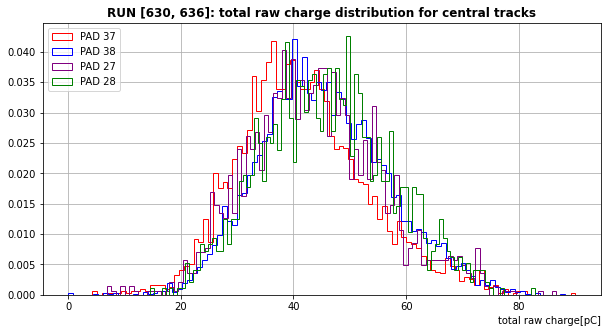

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))
radius =2.5

for index in range(4):
    pad = index+1
    
    xc = centers_from_fit[0][index]
    yc = centers_from_fit[1][index]
    
    #applying transfo.. not so important?
    xc,yc = transfo(xc,yc,cross_beam[0],cross_beam[1],theta_local)
    x =data.iloc[:,-4]
    y =data.iloc[:,-3]
    x,y = transfo(x,y,cross_beam[0],cross_beam[1],theta_local)    
    
    square = np.logical_and(np.abs(x-xc)<=radius, np.abs(y-yc)<=radius)
    
    mm_qall = f'mm{pad}_qall'
    qDist[index] = Distribution(data[mm_qall],mm_basic_cut[index]*square)
    qDist[index].DisplayDensityHist(bins =100, 
            color = color[index],label = f'PAD {pad_name[index]}')
    
ax.set_xlabel('total raw charge[pC]',loc='right')
ax.grid()
ax.legend()
#ax.set_yscale('log')
ax.set_title(f'RUN {run}: total raw charge distribution for central tracks', fontsize=12, fontweight='bold')

plt.show()

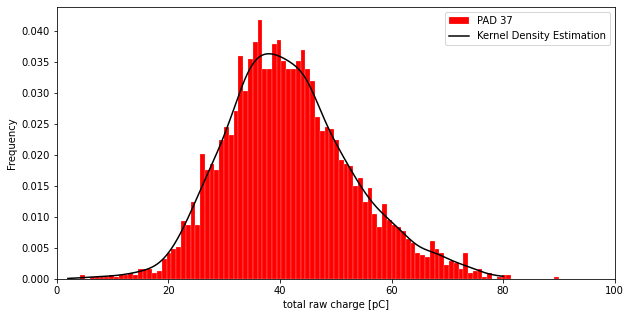

In [14]:
fig, ax = plt.subplots(figsize=(10, 5));

kde = qDist[0].HistKDE()

qDist[0].PandasPlot(color=color[0],bins=100,label=f'PAD {pad_name[0]}',ax=ax)

xs = np.linspace(2.,80.,1000)
ys = kde(xs)
ax.plot(xs,ys,color='black',alpha=1,label ='Kernel Density Estimation')

ax.set_xlabel('total raw charge [pC]')
ax.legend()
ax.set_xlim(0.,100.)

plt.show()

In [15]:
def scale_function(x,p1,p2,p3):
    return p1*kde(p2*x+p3)

scale_p2 = np.ones(4)
scale_p3 = np.zeros(4)

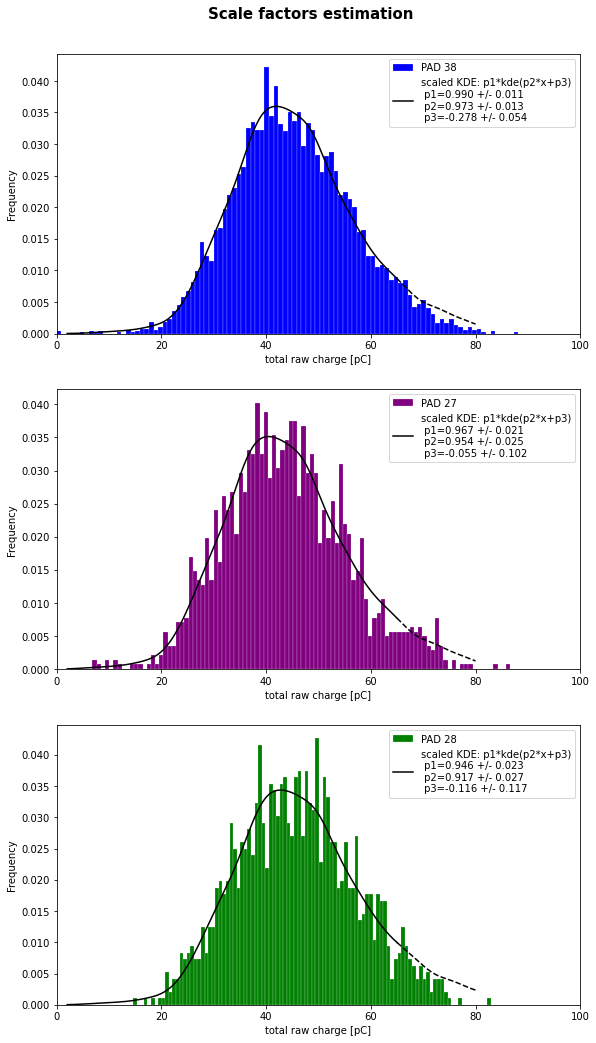

In [16]:
fig, ax = plt.subplots(3,1,figsize=(8,15));
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.subplots_adjust(hspace=0.2)
fig.suptitle('Scale factors estimation', fontsize=15, fontweight='bold')

for index in range(1,4):
    
    qDist[index].PandasPlot(color=color[index],bins=100,label=f'PAD {pad_name[index]}',ax=ax[index-1])
    (p1,p2,p3),(erp1,erp2,erp3) = qDist[index].FitFunction(f=scale_function,p0=(1.,1.,0.), range=[2.,80.])
    
    lab = 'scaled KDE: p1*kde(p2*x+p3)\n p1={:.3f} +/- {:.3f}  \n p2={:.3f} +/- {:.3f} \n p3={:.3f} +/- {:.3f}'.format(p1,erp1,p2,erp2,p3/10,erp3/10)

    xs = np.linspace(2.,65.,1000)
    ys = scale_function(xs,p1,p2,p3)
    ax[index-1].plot(xs,ys,color='black',alpha=1,label=lab)

    xs = np.linspace(65.,80.,350)
    ys = scale_function(xs,p1,p2,p3)
    ax[index-1].plot(xs,ys,'k--',alpha=1)
    
    ax[index-1].set_xlabel('total raw charge [pC]')
    ax[index-1].legend()
    ax[index-1].set_xlim(0,100)
    
    scale_p2[index] = p2
    scale_p3[index] = p3/10

plt.show()

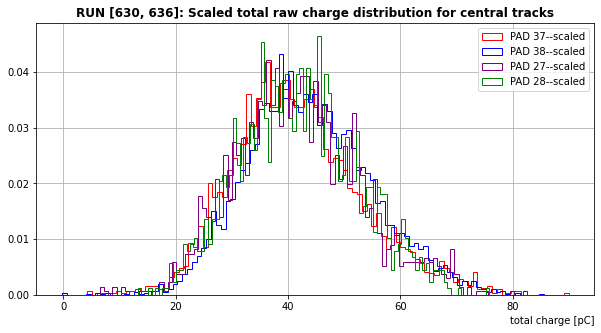

In [17]:
fig, ax = plt.subplots(figsize=(10, 5))
for index in range(4):
    pad = index+1
    
    qDist[index] = Distribution(scale_p2[index]*qDist[index].dataset+scale_p3[index],qDist[index].cut)
    qDist[index].DisplayDensityHist(bins =100, 
            color = color[index],label = f'PAD {pad_name[index]}--scaled')
    
ax.set_xlabel('total charge [pC]',loc='right')
ax.grid()
ax.legend()
#ax.set_yscale('log')
ax.set_title(f'RUN {run}: Scaled total raw charge distribution for central tracks', fontsize=12, fontweight='bold')

plt.show()

In [18]:
scale_p = np.concatenate((scale_p2.reshape(4,1), scale_p3.reshape(4,1)),axis=1)
print(scale_p)
with open(f'/home/evridiki/Desktop/JULY_RUNS/run_{run[0]}_{run[1]}_info/scale_par.txt', 'w') as f:
     np.savetxt(f,scale_p)

[[ 1.          0.        ]
 [ 0.97344831 -0.2777333 ]
 [ 0.9537326  -0.05451041]
 [ 0.91655112 -0.11622711]]


In [19]:
scale_p2 = np.loadtxt('/home/evridiki/Desktop/JULY_RUNS/run_627_632_info/scale_par.txt',
                delimiter=" ", usecols=(0))
scale_p3 = np.loadtxt('/home/evridiki/Desktop/JULY_RUNS/run_627_632_info/scale_par.txt',
                delimiter=" ", usecols=(1))

In [20]:
# we get a square in LOCAL FRAME
x0 = 0
y0 = 0
radius = 2.

x =data.iloc[:,-4]
y =data.iloc[:,-3]
x,y = transfo(x,y,cross_beam[0],cross_beam[1],theta_local)

square_cut = np.logical_and(np.abs(x-x0)<radius, np.abs(y-y0)<radius)

In [21]:
A = data[['mm1_qall','mm2_qall','mm3_qall','mm4_qall']][square_cut].idxmax(axis=1)
A.values

array(['mm3_qall', 'mm4_qall', 'mm4_qall', ..., 'mm3_qall', 'mm4_qall',
       'mm4_qall'], dtype=object)

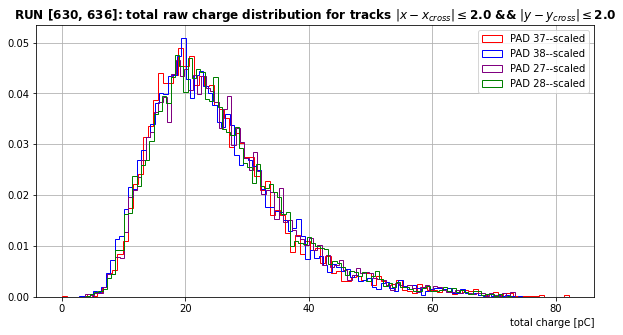

In [22]:
fig, ax = plt.subplots(figsize=(10, 5))
qcrossDist = [None]*4
for index in range(4):
    pad = index+1
    mm_qall = f'mm{pad}_qall'
    qcrossDist[index] = Distribution( scale_p2[index]*data[square_cut][A.values==mm_qall][mm_qall]+scale_p3[index], 
                                     mm_basic_cut[index][square_cut][A.values==mm_qall] )
    
    qcrossDist[index].DisplayDensityHist(bins =100, 
            color = color[index],label = f'PAD {pad_name[index]}--scaled')
    
ax.set_xlabel('total charge [pC]',loc='right')
ax.grid()
ax.legend()
#ax.set_yscale('log')
ax.set_title(f'RUN {run}: total raw charge distribution for tracks '+ 
             r'$|x-x_{cross}|\leq$'+f'{radius}'+
             r' && $|y-y_{cross}|\leq$'+f'{radius}', fontweight='bold')

plt.show()